In [35]:
import requests
import pandas as pd
import numpy as np
import random
import csv
import time,datetime
import json
import pytz
from requests.adapters import HTTPAdapter
from apscheduler.schedulers.background import BackgroundScheduler,BlockingScheduler

In [36]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})   

In [37]:
# 爬虫: 从雪球网爬取股票代码列表
def get_stock_list():
    stockCode_list=[]
    null=""
    false="false"

    headers={
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36',
        'Host':'xueqiu.com'    
    }
    #雪球 -> 沪深股市 -> 沪深一览， 共有52页A股个股数据
    print('开始从雪球网获取股票代码:')
    for page in range(1,53):
        #暂停时间0.1s
        time.sleep(0.1)
        #每次根据页号爬取整页股票数据
        print('正在从雪球爬取第'+str(page)+'页的股票代码...('+str(page)+'/52)')
        xueqiu_url='https://xueqiu.com/service/v5/stock/screener/quote/list?page='+ str(page)+'&size=90&order=desc&orderby=percent&order_by=percent&market=CN&type=sh_sz'
        #获取网页响应内包含的信息
        response=requests.get(xueqiu_url,headers=headers)
        page_data=eval(response.text)
        stock_list=page_data['data']['list']
        #每页显示90条个股数据
        for n in range(0,len(stock_list)):
            stock_code=stock_list[n]['symbol']
            stockCode_list.append(stock_code)
    print('共爬取到',len(stockCode_list),'条股票代码')
    print('')
    return stockCode_list


In [38]:
# 将从雪球网爬取的股票代码列表转换格式，例如 SZ300166 -> 0.300166, SH688680 -> 1.688680
def transfer_stock_list(stock_list):
    stockCode_list_df=[]
    for code in stock_list:
        if code.startswith('SZ'):
            stockCode_list_df.append(code.replace('SZ','0.'))
        if code.startswith('SH'):
            stockCode_list_df.append(code.replace('SH','1.'))
    return stockCode_list_df

In [39]:
# 主爬虫: 获取网页返回的json格式文本
def get_stock_info(stock_code_df,time_stamp):
    headers_df={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36',
    'Connection': 'close',
    'Referer':'http://quote.eastmoney.com/'
    }
    df_url_main='http://push2.eastmoney.com/api/qt/stock/get?ut=fa5fd1943c7b386f172d6893dbfba10b&invt=2&fltt=2&fields='
    fields='f43,f57,f58,f127,f128,f169,f170,f46,f44,f51,f168,f47,f48,f164,f163,f116,f60,f45,f52,f50,f167,f117,f71,f161,f49,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f191,f192,f260,f261,f288,f294,f171&secid='
    df_url_whole=df_url_main+fields+stock_code_df
    requests.encoding='utf-8'
    s = requests.Session()
    s.mount('http://', HTTPAdapter(max_retries=3))
    s.mount('https://', HTTPAdapter(max_retries=3))
    res_df=s.get(df_url_whole,headers=headers_df,timeout=5)
    res_df_text=str(res_df.text)
    return res_df_text

In [40]:
# 主爬虫: 解析json文本，循环爬取，存储数据，打印爬取过程和结果，并最终写入CSV文件
def get_allStock_today(stock_list):   
    stockCode_list_df=transfer_stock_list(stock_list)
    
    #定义存储不同数据的列表
    f43=[]#最新价
    f57=[]#股票代码
    f58=[]#股票名称
    markets=[]#市场
    f127=[]#所属行业
    f128=[]#所属板块
    f169=[]#涨跌
    f170=[]#涨幅
    f46=[]#今开
    f44=[]#最高
    f51=[]#涨停
    f168=[]#换手率
    f47=[]#成交量
    f48=[]#成交额
    f164=[]#市盈（动）
    f163=[]#市盈（静）
    f116=[]#总市值
    f60=[]#昨收
    f45=[]#最低
    f52=[]#跌停
    f50=[]#量比
    f167=[]#市净
    f117=[]#流通市值
    f71=[]#均价
    f161=[]#内盘
    f49=[]#外盘
    f135=[]#今日主力流入
    f136=[]#今日主力流出
    f137=[]#今日主力净流入
    f138=[]#今日超大单流入
    f139=[]#今日超大单流出
    f140=[]#今日超大单净流入
    f141=[]#今日大单流入
    f142=[]#今日大单流出
    f143=[]#今日大单净流入
    f144=[]#今日中单流入
    f145=[]#今日中单流出
    f146=[]#今日中单净流入
    f147=[]#今日小单流入
    f148=[]#今日小单流出
    f149=[]#今日小单净流入
    f191=[]#委比
    f192=[]#委差
    f260=[]#盘后成交量
    f261=[]#盘后成交额
    f288=[]#是否盈利
    f294=[]#是否是注册制
    f171=[]#振幅
    
    
    now_day=datetime.datetime.now(pytz.timezone('PRC')).strftime("%Y-%m-%d")
    new_file_name='Stock_'+str(now_day)+'.csv'

    time_stamp = time.time()    #取出时间戳
    time_stamp = int(time_stamp*1000)
    count=0 #爬取个股计数器
    print('准备从东方财富->沪深A股的详情页爬取个股日线行情数据...')
    index=0
    for stockCode in stockCode_list_df:
        try:
            market=stockCode.split('.')[0]
            count+=1
            print('---正在爬取',stockCode,'的股票信息...('+str(count)+'/'+str(len(stockCode_list_df))+')')
            stock_json=get_stock_info(stockCode,time_stamp)
            stock_data=json.loads(stock_json)['data']
            
            
            f57.append(stock_list[index])
            f58.append(stock_data['f58'])
            markets.append(stockCode.split('.')[0])        
            f127.append(stock_data['f127'])
            f128.append(stock_data['f128'])
            f43.append(stock_data['f43'])
            f169.append(stock_data['f169'])
            f170.append(stock_data['f170'])
            f46.append(stock_data['f46'])
            f44.append(stock_data['f44'])
            f51.append(stock_data['f51'])
            f168.append(stock_data['f168'])
            f47.append(stock_data['f47'])
            f48.append(stock_data['f48'])
            f164.append(stock_data['f164'])
            f163.append(stock_data['f163'])
            f116.append(stock_data['f116'])
            f60.append(stock_data['f60'])
            f45.append(stock_data['f45'])
            f52.append(stock_data['f52'])
            f50.append(stock_data['f50'])
            f167.append(stock_data['f167'])
            f117.append(stock_data['f117'])
            f71.append(stock_data['f71'])
            f161.append(stock_data['f161'])
            f49.append(stock_data['f49'])
            f135.append(stock_data['f135'])
            f136.append(stock_data['f136'])
            f137.append(stock_data['f137'])
            f138.append(stock_data['f138'])
            f139.append(stock_data['f139'])
            f140.append(stock_data['f140'])
            f141.append(stock_data['f141'])
            f142.append(stock_data['f142'])
            f143.append(stock_data['f143'])
            f144.append(stock_data['f144'])
            f145.append(stock_data['f145'])
            f146.append(stock_data['f146'])
            f147.append(stock_data['f147'])
            f148.append(stock_data['f148'])
            f149.append(stock_data['f149'])
            f191.append(stock_data['f191'])
            f192.append(stock_data['f192'])
            f260.append(stock_data['f260'])
            f261.append(stock_data['f261'])
            f288.append(stock_data['f288'])
            f294.append(stock_data['f294'])
            f171.append(stock_data['f171'])
            index+=1
        except requests.exceptions.RequestException as e:
            print(e)
            continue
    print('今日A股个股日线行情爬取完毕')
    
    print('开始将当日A股个股日线行情写入CSV文件')
    with open(new_file_name,'w',newline='',encoding='gb18030') as csvfile:
        csvwriter=csv.writer(csvfile)
        csvwriter.writerow(['股票代码','股票名称','市场','所属行业','所属板块','最新价','涨跌','涨幅','今开','最高','涨停','换手率','成交量','成交额','市盈(动)','市盈(静)',
                            '总市值','昨收','最低','跌停','量比','市净','流通市值','均价','内盘','外盘','今日主力流入','今日主力流出','今日主力净流入',
                            '今日超大单流入','今日超大单流出','今日超大单净流入','今日大单流入','今日大单流出','今日大单净流入','今日中单流入',
                            '今日中单流出','今日中单净流入','今日小单流入','今日小单流出','今日小单净流入','委比','委差','盘后成交量','盘后成交额',
                            '是否盈利','是否注册制','振幅'])
        for R57,R58,Rmkt,R127,R128,R43,R169,R170,R46,R44,R51,R168,R47,R48,R164,R163,R116,R60,R45,R52,R50,R167,R117,R71,R161,R49,R135,R136,R137,R138,R139,R140,R141,R142,R143,R144,R145,R146,R147,R148,R149,R191,R192,R260,R261,R288,R294,R171 in zip(f57,f58,markets,f127,f128,f43,f169,f170,f46,f44,f51,f168,f47,f48,f164,f163,f116,f60,f45,f52,f50,f167,f117,f71,f161,f49,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f191,f192,f260,f261,f288,f294,f171):        
            csvwriter.writerow([R57,R58,Rmkt,R127,R128,R43,R169,R170,R46,R44,R51,R168,R47,R48,R164,R163,R116,R60,R45,R52,R50,R167,R117,R71,R161,R49,R135,R136,R137,R138,R139,R140,R141,R142,R143,R144,R145,R146,R147,R148,R149,R191,R192,R260,R261,R288,R294,R171])
    print('A股个股日线行情数据写入CSV文件成功')
    return new_file_name

In [41]:
# 主爬虫: 封装爬虫到方法里，以便后续添加到每日实盘任务中
def get_stocks_perday(stockCode_list_df):
    print('=======================================================================')
    #获取北京时区当前时间
    now_time=datetime.datetime.now(pytz.timezone('PRC')).strftime("%Y-%m-%d %H:%M:%S")
    print('现在是北京时间 ',now_time)
    print('开始爬取今日A股日线行情...')
    today_file=get_allStock_today(stockCode_list_df)
    print('今日爬取任务完成,已存入文件: ',today_file)
    return today_file

In [42]:
#获取雪球网股票代码列表
stockCode_list=get_stock_list() 

#演示运行
#运行完整爬虫大约用时1小时
today_csv=get_stocks_perday(stockCode_list)
    
#模拟实盘操作, 此方法仅会在指定的时间启动爬虫任务，其余时间不会阻塞当前内核中的其他进程运行
scheduler = BackgroundScheduler()
#将每日需要调用的方法添加到 apscheduler
#每周一至周五，北京时间16:00运行爬虫任务
scheduler.add_job(get_stocks_perday,'cron',day_of_week='mon-fri',hour=16,timezone=pytz.timezone('Asia/Shanghai'),args=[stockCode_list]) 
scheduler.start()

开始从雪球网获取股票代码:
正在从雪球爬取第1页的股票代码...(1/52)
正在从雪球爬取第2页的股票代码...(2/52)
正在从雪球爬取第3页的股票代码...(3/52)
正在从雪球爬取第4页的股票代码...(4/52)
正在从雪球爬取第5页的股票代码...(5/52)
正在从雪球爬取第6页的股票代码...(6/52)
正在从雪球爬取第7页的股票代码...(7/52)
正在从雪球爬取第8页的股票代码...(8/52)
正在从雪球爬取第9页的股票代码...(9/52)
正在从雪球爬取第10页的股票代码...(10/52)
正在从雪球爬取第11页的股票代码...(11/52)
正在从雪球爬取第12页的股票代码...(12/52)
正在从雪球爬取第13页的股票代码...(13/52)
正在从雪球爬取第14页的股票代码...(14/52)
正在从雪球爬取第15页的股票代码...(15/52)
正在从雪球爬取第16页的股票代码...(16/52)
正在从雪球爬取第17页的股票代码...(17/52)
正在从雪球爬取第18页的股票代码...(18/52)
正在从雪球爬取第19页的股票代码...(19/52)
正在从雪球爬取第20页的股票代码...(20/52)
正在从雪球爬取第21页的股票代码...(21/52)
正在从雪球爬取第22页的股票代码...(22/52)
正在从雪球爬取第23页的股票代码...(23/52)
正在从雪球爬取第24页的股票代码...(24/52)
正在从雪球爬取第25页的股票代码...(25/52)
正在从雪球爬取第26页的股票代码...(26/52)
正在从雪球爬取第27页的股票代码...(27/52)
正在从雪球爬取第28页的股票代码...(28/52)
正在从雪球爬取第29页的股票代码...(29/52)
正在从雪球爬取第30页的股票代码...(30/52)
正在从雪球爬取第31页的股票代码...(31/52)
正在从雪球爬取第32页的股票代码...(32/52)
正在从雪球爬取第33页的股票代码...(33/52)
正在从雪球爬取第34页的股票代码...(34/52)
正在从雪球爬取第35页的股票代码...(35/52)
正在从雪球爬取第36页的股票代码...(36/52)
正在从雪球爬取第37页的股票代码...(37/52)
正在从雪球

In [43]:
# 爬虫: 爬取指定股票的历史日K线数据
def get_stock_kline(stock_code_df):
    headers_kline={
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36',
        'Connection': 'close',
        'Referer':'http://quote.eastmoney.com/'
    }
    kline_url='http://push2his.eastmoney.com/api/qt/stock/kline/get?fields1=f1,f2,f3,f4,f5,f6&fields2=f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61&ut=fa5fd1943c7b386f172d6893dbfba10b&klt=101&fqt=1&secid='+stock_code_df+'&beg=0&end=20500000'
    requests.encoding='utf-8'
    s = requests.Session()
    s.mount('http://', HTTPAdapter(max_retries=3))
    s.mount('https://', HTTPAdapter(max_retries=3))
    kline_text=s.get(kline_url,headers=headers_kline,timeout=5)
    kline_text=str(kline_text.text)
    return kline_text

In [44]:
# 爬虫: 根据输入的股票代码爬取此股票的全部历史日K线数据
# 包含日期、开盘价、收盘价、最高、最低、成交量、成交额、振幅、涨跌幅、涨跌额、换手率
stockCode_list_df=transfer_stock_list(stockCode_list)
stockCode_list_c=[stockCode_list_df[i].split('.')[1] for i in range(0,len(stockCode_list_df))]
stock_need=input('请输入您想要查询的股票代码(形式如301185):')
stock_index=stockCode_list_c.index(stock_need)
kline_text=get_stock_kline(stockCode_list_df[stock_index])
klines=json.loads(kline_text)['data']['klines']
new_kl_list=[]
for strkline in klines:
    new_kl_list.append(strkline.split(','))
stock_kline=pd.DataFrame(new_kl_list)
stock_kline.columns=['日期','开盘价','收盘价','最高','最低','成交量','成交额','振幅','涨跌幅','涨跌额','换手率']
print('股票',stock_need,'的历史日K线数据显示如下:')
stock_kline

请输入您想要查询的股票代码(形式如301185):600500
股票 600500 的历史日K线数据显示如下:


日期    开盘价    收盘价    最高     最低     成交量           成交额        振幅  \
0     2000-03-01   0.04  -0.06  0.11  -0.16  532402  604672000.00    -38.57   
1     2000-03-02  -0.11  -0.05  0.00  -0.15  149606  167217000.00   -250.00   
2     2000-03-03  -0.05  -0.02  0.02  -0.08  105072  120890000.00   -200.00   
3     2000-03-06  -0.02   0.08  0.20  -0.02  247512  308250000.00  -1100.00   
4     2000-03-07   0.02   0.01  0.08  -0.05   90458  105222000.00    162.50   
...          ...    ...    ...   ...    ...     ...           ...       ...   
5178  2021-11-15   7.44   7.29  7.46   7.24  299044  218390429.00      2.96   
5179  2021-11-16   7.30   7.13  7.34   7.12  272572  196771224.00      3.02   
5180  2021-11-17   7.11   7.29  7.35   7.09  310184  225077630.00      3.65   
5181  2021-11-18   7.29   7.36  7.42   7.27  304477  224004485.00      2.06   
5182  2021-11-19   8.10   8.10  8.10   8.10  144277  116864030.00      0.00   

         涨跌幅    涨跌额    换手率  
0      91.43   0.64  50.70  
1      16.67   0.01  14.25  
2      60.00   0.03  10.01  
3     500.00   0.10  23.57  
4     -87.50  -0.07   8.62  
...      ...    ...    ...  
5178   -2.02  -0.15   1.10  
5179   -2.19  -0.16   1.01  
5180    2.24   0.16   1.15  
5181    0.96   0.07   1.12  
5182   10.05   0.74   0.53  

[5183 rows x 11 columns]

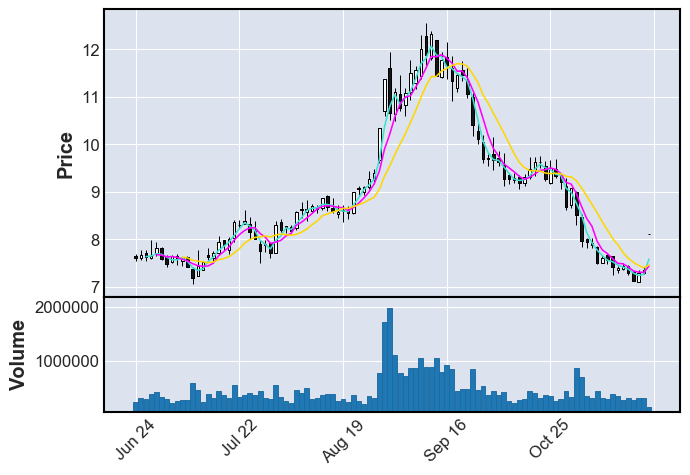

In [45]:
import mplfinance as mpf
stock_kline[['开盘价','收盘价','最高','最低','成交量','成交额','振幅','涨跌幅','涨跌额','换手率']]=stock_kline[['开盘价','收盘价','最高','最低','成交量','成交额','振幅','涨跌幅','涨跌额','换手率']].astype(float)

kline_figure=stock_kline[['日期','开盘价','最高','最低','收盘价','成交量']].rename(columns={'日期':'Date','开盘价':'Open','最高':'High','最低':'Low','收盘价':'Close','成交量':'Volume'})
kline_figure.index=pd.to_datetime(kline_figure['Date'])
kline_figure.set_index('Date')
#全时间维度折线图
# mpf.plot(kline_figure, type='line',mav=(3,5,10),volume=True)
#蜡烛图的时间维度尽量不要太大，不然无法显示
mpf.plot(kline_figure.tail(100), type='candle',mav=(3,5,10),volume=True)

In [12]:
##################################################################################

In [20]:
# 对当日数据进行简单聚合分析

In [46]:
#读取今日爬取的A股个股信息文件(日期可根据上述爬虫任务返回的结果进行改动)
df_today_stocks=pd.read_csv('Stock_2021-11-20.csv',encoding='gb18030')
df_today_stocks

股票代码   股票名称  市场   所属行业  所属板块    最新价     涨跌      涨幅     今开     最高  \
0     SZ301185    N鸥玛   0   软件服务  山东板块  31.58   19.7  165.82   34.0   34.0   
1     SZ300943   春晖智控   0   机械行业  浙江板块   27.4   4.57   20.02  22.34   27.4   
2     SZ300435   中泰股份   0     燃气  浙江板块  24.59    4.1   20.01  19.82  24.59   
3     SZ301072   中捷精工   0  汽车零部件  江苏板块  47.33   7.89   20.01  38.27  47.33   
4     SZ301022    海泰科   0  汽车零部件  山东板块  48.76   8.13   20.01   45.0  48.76   
...        ...    ...  ..    ...   ...    ...    ...     ...    ...    ...   
4633  SZ002056   横店东磁   0    小金属  浙江板块  16.75  -1.37   -7.56  17.84  17.96   
4634  SZ000567   海德股份   0   多元金融  海南板块  15.88  -1.68   -9.57   15.8  16.52   
4635  SZ002408   齐翔腾达   0   化学制品  山东板块   8.64  -0.96   -10.0   8.64   8.64   
4636  SZ000670  *ST盈方   0   电子信息  湖北板块      -      -       -      -      -   
4637  SZ002260  *ST德奥   0   家电行业  广东板块      -      -       -      -      -   

      ...       今日小单流入       今日小单流出       今日小单净流入      委比       委差  盘后成交量  \
0     ...  287274000.0  582296832.0  -295022832.0    7.66       88     28   
1     ...   61650789.0   98080993.0   -36430204.0   100.0    15796      -   
2     ...  169582818.0  263857050.0   -94274232.0   100.0    43211      9   
3     ...  210384740.0  181225907.0    29158833.0   100.0    13533     13   
4     ...   36947750.0   63000347.0   -26052597.0   100.0     8999      -   
...   ...          ...          ...           ...     ...      ...    ...   
4633  ...  785891280.0  584963056.0   200928224.0   58.59     6862      -   
4634  ...  135750972.0  108972085.0    26778887.0    50.8     1534      -   
4635  ...   61402752.0   12710960.0    48691792.0  -100.0  -568293      -   
4636  ...            -            -             -       -        -      -   
4637  ...            -            -             -       -        -      -   

        盘后成交额  是否盈利 是否注册制     振幅  
0     88424.0     0     1  22.73  
1           -     0     1  22.16  
2     22131.0     0     0  23.33  
3     61529.0     0     1  22.97  
4           -     0     1   9.25  
...       ...   ...   ...    ...  
4633        -     0     0   9.05  
4634        -     0     0    4.1  
4635        -     0     0    0.0  
4636        -    -1     -      -  
4637        -    -1     -      -  

[4638 rows x 48 columns]

In [47]:
# 缺失值用0填充
df_today_stocks.replace({'-': '0'},inplace=True)
# 强制类型转换
df_today_stocks[['最新价','涨跌','涨幅','今开','最高','涨停','换手率','成交量','成交额','市盈(动)','市盈(静)',
                            '总市值','昨收','最低','跌停','量比','市净','流通市值','均价','内盘','外盘','今日主力流入','今日主力流出','今日主力净流入',
                            '今日超大单流入','今日超大单流出','今日超大单净流入','今日大单流入','今日大单流出','今日大单净流入','今日中单流入',
                            '今日中单流出','今日中单净流入','今日小单流入','今日小单流出','今日小单净流入','委比','委差','盘后成交量','盘后成交额','振幅']] = df_today_stocks[['最新价','涨跌','涨幅','今开','最高','涨停','换手率','成交量','成交额','市盈(动)','市盈(静)',
                            '总市值','昨收','最低','跌停','量比','市净','流通市值','均价','内盘','外盘','今日主力流入','今日主力流出','今日主力净流入',
                            '今日超大单流入','今日超大单流出','今日超大单净流入','今日大单流入','今日大单流出','今日大单净流入','今日中单流入',
                            '今日中单流出','今日中单净流入','今日小单流入','今日小单流出','今日小单净流入','委比','委差','盘后成交量','盘后成交额','振幅']].astype(float)
df_today_stocks

股票代码   股票名称  市场   所属行业  所属板块    最新价     涨跌      涨幅     今开     最高  \
0     SZ301185    N鸥玛   0   软件服务  山东板块  31.58  19.70  165.82  34.00  34.00   
1     SZ300943   春晖智控   0   机械行业  浙江板块  27.40   4.57   20.02  22.34  27.40   
2     SZ300435   中泰股份   0     燃气  浙江板块  24.59   4.10   20.01  19.82  24.59   
3     SZ301072   中捷精工   0  汽车零部件  江苏板块  47.33   7.89   20.01  38.27  47.33   
4     SZ301022    海泰科   0  汽车零部件  山东板块  48.76   8.13   20.01  45.00  48.76   
...        ...    ...  ..    ...   ...    ...    ...     ...    ...    ...   
4633  SZ002056   横店东磁   0    小金属  浙江板块  16.75  -1.37   -7.56  17.84  17.96   
4634  SZ000567   海德股份   0   多元金融  海南板块  15.88  -1.68   -9.57  15.80  16.52   
4635  SZ002408   齐翔腾达   0   化学制品  山东板块   8.64  -0.96  -10.00   8.64   8.64   
4636  SZ000670  *ST盈方   0   电子信息  湖北板块   0.00   0.00    0.00   0.00   0.00   
4637  SZ002260  *ST德奥   0   家电行业  广东板块   0.00   0.00    0.00   0.00   0.00   

      ...       今日小单流入       今日小单流出      今日小单净流入      委比        委差  盘后成交量  \
0     ...  287274000.0  582296832.0 -295022832.0    7.66      88.0   28.0   
1     ...   61650789.0   98080993.0  -36430204.0  100.00   15796.0    0.0   
2     ...  169582818.0  263857050.0  -94274232.0  100.00   43211.0    9.0   
3     ...  210384740.0  181225907.0   29158833.0  100.00   13533.0   13.0   
4     ...   36947750.0   63000347.0  -26052597.0  100.00    8999.0    0.0   
...   ...          ...          ...          ...     ...       ...    ...   
4633  ...  785891280.0  584963056.0  200928224.0   58.59    6862.0    0.0   
4634  ...  135750972.0  108972085.0   26778887.0   50.80    1534.0    0.0   
4635  ...   61402752.0   12710960.0   48691792.0 -100.00 -568293.0    0.0   
4636  ...          0.0          0.0          0.0    0.00       0.0    0.0   
4637  ...          0.0          0.0          0.0    0.00       0.0    0.0   

        盘后成交额  是否盈利  是否注册制     振幅  
0     88424.0     0      1  22.73  
1         0.0     0      1  22.16  
2     22131.0     0      0  23.33  
3     61529.0     0      1  22.97  
4         0.0     0      1   9.25  
...       ...   ...    ...    ...  
4633      0.0     0      0   9.05  
4634      0.0     0      0   4.10  
4635      0.0     0      0   0.00  
4636      0.0    -1      0   0.00  
4637      0.0    -1      0   0.00  

[4638 rows x 48 columns]

In [48]:
# 根据每日的成交额和成交量添加 成交均单价 列
def deal_avg(dl_cje,dl_cjl):
    if dl_cjl!=0.0 :
        return float(dl_cje)/float(dl_cjl)
df_today_stocks['成交均单价']=df_today_stocks.apply(lambda x:deal_avg(x['成交额'],x['成交量']),axis=1)
df_today_stocks[['股票代码','股票名称','成交均单价']]

股票代码   股票名称        成交均单价
0     SZ301185    N鸥玛  3218.183378
1     SZ300943   春晖智控  2552.614458
2     SZ300435   中泰股份  2273.754967
3     SZ301072   中捷精工  4374.844990
4     SZ301022    海泰科  4814.679333
...        ...    ...          ...
4633  SZ002056   横店东磁  1681.877668
4634  SZ000567   海德股份  1596.851266
4635  SZ002408   齐翔腾达   864.000000
4636  SZ000670  *ST盈方          NaN
4637  SZ002260  *ST德奥          NaN

[4638 rows x 3 columns]

In [49]:
#将当日A股个股日线数据按换手率从高到低排列（可替换成涨跌、涨幅、振幅等其他指标）
df_today_stocks[['股票代码','股票名称','换手率']].sort_values('换手率',ascending=False)

股票代码   股票名称    换手率
3     SZ301072   中捷精工  70.83
0     SZ301185    N鸥玛  70.75
58    SH603048   浙江黎明  65.16
4576  SZ300774    倍杰特  62.62
4553  SZ301118    C恒光  56.90
...        ...    ...    ...
3366  SZ301089   拓新药业   0.00
3395  SZ300599   雄塑科技   0.00
3414  SH601069   西部黄金   0.00
3500  SH600318   新力金融   0.00
4637  SZ002260  *ST德奥   0.00

[4638 rows x 3 columns]

In [50]:
# 当日涨停股
df_today_stocks[df_today_stocks['最高']==df_today_stocks['涨停']]

股票代码   股票名称  市场    所属行业  所属板块    最新价    涨跌     涨幅     今开     最高  \
1     SZ300943   春晖智控   0    机械行业  浙江板块  27.40  4.57  20.02  22.34  27.40   
2     SZ300435   中泰股份   0      燃气  浙江板块  24.59  4.10  20.01  19.82  24.59   
3     SZ301072   中捷精工   0   汽车零部件  江苏板块  47.33  7.89  20.01  38.27  47.33   
4     SZ301022    海泰科   0   汽车零部件  山东板块  48.76  8.13  20.01  45.00  48.76   
5     SZ301079   邵阳液压   0    机械行业  湖南板块  40.36  6.73  20.01  32.81  40.36   
...        ...    ...  ..     ...   ...    ...   ...    ...    ...    ...   
1545  SZ002164   宁波东力   0    专用设备  浙江板块   5.78  0.08   1.40   5.95   6.27   
2795  SZ001267   汇绿生态   0  工程咨询服务  湖北板块   6.65  0.03   0.45   6.58   7.28   
4573  SZ002210  *ST飞马   0    综合行业  广东板块   3.36 -0.13  -3.72   3.66   3.66   
4636  SZ000670  *ST盈方   0    电子信息  湖北板块   0.00  0.00   0.00   0.00   0.00   
4637  SZ002260  *ST德奥   0    家电行业  广东板块   0.00  0.00   0.00   0.00   0.00   

      ...       今日小单流出      今日小单净流入      委比       委差  盘后成交量    盘后成交额  是否盈利  \
1     ...   98080993.0  -36430204.0  100.00  15796.0    0.0      0.0     0   
2     ...  263857050.0  -94274232.0  100.00  43211.0    9.0  22131.0     0   
3     ...  181225907.0   29158833.0  100.00  13533.0   13.0  61529.0     0   
4     ...   63000347.0  -26052597.0  100.00   8999.0    0.0      0.0     0   
5     ...   85525762.0  -22616947.0  100.00   8602.0    4.0  16144.0     0   
...   ...          ...          ...     ...      ...    ...      ...   ...   
1545  ...  118342168.0    3004899.0   -8.87   -784.0    0.0      0.0     0   
2795  ...   90606223.0  238412769.0   41.82   5055.0    0.0      0.0     0   
4573  ...   44285486.0   43054342.0   50.92  20783.0    0.0      0.0     0   
4636  ...          0.0          0.0    0.00      0.0    0.0      0.0    -1   
4637  ...          0.0          0.0    0.00      0.0    0.0      0.0    -1   

      是否注册制     振幅        成交均单价  
1         1  22.16  2552.614458  
2         0  23.33  2273.754967  
3         1  22.97  4374.844990  
4         1   9.25  4814.679333  
5         1  22.99  3680.396683  
...     ...    ...          ...  
1545      0   9.12   604.678884  
2795      0  14.95   683.301411  
4573      0   9.46   351.535750  
4636      0   0.00          NaN  
4637      0   0.00          NaN  

[120 rows x 49 columns]

In [51]:
#当日振幅最大的股票
df_today_stocks[df_today_stocks['振幅']==df_today_stocks['振幅'].max()]

股票代码  股票名称  市场  所属行业  所属板块   最新价    涨跌     涨幅    今开    最高  ...  \
7  SZ300985  致远新能   0  金属制品  吉林板块  40.4  6.73  19.99  32.0  40.4  ...   

        今日小单流出     今日小单净流入     委比       委差  盘后成交量  盘后成交额  是否盈利  是否注册制     振幅  \
7  178216645.0 -31907168.0  100.0  10435.0    0.0    0.0     0      1  25.78   

         成交均单价  
7  3618.058761  

[1 rows x 49 columns]

In [52]:
#今日主力净流入为正的股票
df_today_stocks[df_today_stocks['今日主力净流入']>0]

股票代码  股票名称  市场   所属行业  所属板块    最新价     涨跌      涨幅     今开      最高  \
0     SZ301185   N鸥玛   0   软件服务  山东板块  31.58  19.70  165.82  34.00   34.00   
1     SZ300943  春晖智控   0   机械行业  浙江板块  27.40   4.57   20.02  22.34   27.40   
2     SZ300435  中泰股份   0     燃气  浙江板块  24.59   4.10   20.01  19.82   24.59   
4     SZ301022   海泰科   0  汽车零部件  山东板块  48.76   8.13   20.01  45.00   48.76   
5     SZ301079  邵阳液压   0   机械行业  湖南板块  40.36   6.73   20.01  32.81   40.36   
...        ...   ...  ..    ...   ...    ...    ...     ...    ...     ...   
4571  SZ300421  力星股份   0   金属制品  江苏板块  23.95  -0.91   -3.66  24.01   24.69   
4572  SH603429  集友股份   1   造纸印刷  安徽板块  27.48  -1.05   -3.68  27.53   28.20   
4599  SZ300390  天华超净   0   电子元件  江苏板块  97.70  -4.75   -4.64  99.00  102.06   
4608  SZ002852   道道全   0   食品饮料  湖南板块  15.90  -0.83   -4.96  16.74   16.98   
4620  SZ300057  万顺新材   0   有色金属  广东板块   9.20  -0.51   -5.25   9.71    9.89   

      ...       今日小单流出      今日小单净流入      委比       委差  盘后成交量    盘后成交额  是否盈利  \
0     ...  582296832.0 -295022832.0    7.66     88.0   28.0  88424.0     0   
1     ...   98080993.0  -36430204.0  100.00  15796.0    0.0      0.0     0   
2     ...  263857050.0  -94274232.0  100.00  43211.0    9.0  22131.0     0   
4     ...   63000347.0  -26052597.0  100.00   8999.0    0.0      0.0     0   
5     ...   85525762.0  -22616947.0  100.00   8602.0    4.0  16144.0     0   
...   ...          ...          ...     ...      ...    ...      ...   ...   
4571  ...   74223262.0    4796144.0  -17.72    -28.0    2.0   4790.0     0   
4572  ...   56789717.0     123308.0  -54.99   -379.0    0.0      0.0     0   
4599  ...  635466256.0  -21867536.0    9.32     49.0    7.0  68390.0     0   
4608  ...   80688650.0   12468834.0  -82.02  -3193.0    0.0      0.0     0   
4620  ...  142914370.0  -19223327.0   19.93    417.0   10.0   9200.0     0   

      是否注册制     振幅        成交均单价  
0         1  22.73  3218.183378  
1         1  22.16  2552.614458  
2         0  23.33  2273.754967  
4         1   9.25  4814.679333  
5         1  22.99  3680.396683  
...     ...    ...          ...  
4571      0   4.79  2397.920538  
4572      0   5.40  2752.837554  
4599      0   5.45  9881.501517  
4608      0   7.83  1608.003747  
4620      0  10.30   920.455067  

[1905 rows x 49 columns]

In [28]:
# 按行业、板块、市场等维度划分

In [53]:
#统计每个行业的个股数量
df_hangye=df_today_stocks.groupby('所属行业').count()
df_hangye=df_hangye[['股票代码']].rename(columns={'股票代码':'数量'})
df_hangye

数量
所属行业      
专用设备   178
交运物流    61
交运设备    34
仪器仪表    71
保险       6
...    ...
钢铁行业    48
银行      41
非金属材料   15
食品饮料   103
高速公路    20

[70 rows x 1 columns]

In [54]:
# 每个行业当日涨停股的数量
df_today_stocks[df_today_stocks['最高']==df_today_stocks['涨停']].groupby('所属行业').count()[['股票代码']].rename(columns={'股票代码':'数量'})

数量
所属行业      
专用设备     5
交运物流     4
仪器仪表     2
农牧饲渔     1
券商信托     2
化学制品     4
化学原料     5
化纤行业     1
化肥行业     2
医疗行业     1
医药制造     3
塑料制品     3
家电行业     1
工程咨询服务   1
工程建设     2
房地产      5
文化传媒     5
有色金属     3
机械行业     9
汽车整车     2
汽车零部件   12
煤炭行业     1
燃气       2
玻璃玻纤     1
珠宝首饰     1
电信运营     1
电子信息     4
电子元件    10
石油行业     2
纺织服装     2
综合行业     4
装修建材     1
装修装饰     2
软件服务     1
输配电气     7
通讯行业     3
金属制品     3
食品饮料     1
高速公路     1

In [55]:
# 列出每个行业当日成交量最大的个股信息
df_today_stocks.groupby('所属行业').apply(lambda x: x[x['成交量']==x['成交量'].max()])
# df_today_stocks.sort_values(by='涨幅',ascending=False).groupby('所属板块').first()

股票代码  股票名称  市场   所属行业  所属板块    最新价    涨跌     涨幅     今开     最高  \
所属行业                                                                            
专用设备  140   SZ002270  华明装备   0   专用设备  山东板块  11.48  0.81   7.59  11.10  11.74   
交运物流  36    SH600057  厦门象屿   1   交运物流  福建板块   8.43  0.77  10.05   7.71   8.43   
交运设备  2978  SH601766  中国中车   1   交运设备  北京板块   6.00  0.02   0.33   5.95   6.01   
仪器仪表  472   SH601222  林洋能源   1   仪器仪表  江苏板块  11.57  0.43   3.86  11.20  11.78   
保险    2162  SH601318  中国平安   1     保险  广东板块  49.96  0.45   0.91  49.40  50.11   
...              ...   ...  ..    ...   ...    ...   ...    ...    ...    ...   
钢铁行业  2314  SH600010  包钢股份   1   钢铁行业   内蒙古   2.52  0.02   0.80   2.49   2.52   
银行    2490  SH601288  农业银行   1     银行  北京板块   2.95  0.02   0.68   2.93   2.95   
非金属材料 221   SH600330  天通股份   1  非金属材料  浙江板块  16.45  0.90   5.79  15.71  16.76   
食品饮料  4628  SH600737  中粮糖业   1   食品饮料  新疆板块   9.83 -0.66  -6.29  10.00  10.05   
高速公路  1575  SH600035  楚天高速   1   高速公路  湖北板块   2.96  0.04   1.37   2.92   2.96   

            ...       今日小单流出      今日小单净流入     委比        委差  盘后成交量  盘后成交额  \
所属行业        ...                                                            
专用设备  140   ...  329669744.0  230315328.0 -25.13   -3733.0    0.0    0.0   
交运物流  36    ...  228190140.0   -4032059.0  33.97    2608.0    0.0    0.0   
交运设备  2978  ...   60539641.0   18148928.0 -15.27  -13788.0    0.0    0.0   
仪器仪表  472   ...  312303632.0  -13077440.0 -69.33  -20387.0    0.0    0.0   
保险    2162  ...  474438608.0   13455792.0 -74.31   -3887.0    0.0    0.0   
...         ...          ...          ...    ...       ...    ...    ...   
钢铁行业  2314  ...  380836976.0   14653168.0 -32.96 -394673.0    0.0    0.0   
银行    2490  ...  112872175.0  -15337950.0  -7.65 -125397.0    0.0    0.0   
非金属材料 221   ...  419913072.0  -73757360.0  44.75    1851.0    0.0    0.0   
食品饮料  4628  ...  271133840.0   79469872.0  38.24   10213.0    0.0    0.0   
高速公路  1575  ...   11302603.0    1056396.0  -5.95   -3137.0    0.0    0.0   

            是否盈利  是否注册制    振幅        成交均单价  
所属行业                                        
专用设备  140      0      0  7.78  1140.975357  
交运物流  36       0      0  9.79   828.226476  
交运设备  2978     0      0  1.17   596.999194  
仪器仪表  472      0      0  6.91  1143.025350  
保险    2162     0      0  1.74  4972.879610  
...          ...    ...   ...          ...  
钢铁行业  2314     0      0  3.20   248.124193  
银行    2490     0      0  0.68   293.954054  
非金属材料 221      0      0  7.59  1630.234343  
食品饮料  4628     0      0  4.39   981.125768  
高速公路  1575     0      0  1.71   294.033350  

[70 rows x 49 columns]

In [56]:
# 根据所属板块和所属行业分组对成交量和成交额求和
df_today_stocks.groupby(by=['所属行业','所属板块']).sum()[['成交量','成交额']]

成交量           成交额
所属行业 所属板块                        
专用设备 上海板块  810493.0  3.866258e+09
     北京板块  145556.0  9.229957e+08
     吉林板块    8657.0  6.300891e+07
     四川板块  337763.0  5.934059e+08
     天津板块   22000.0  8.660092e+07
...             ...           ...
高速公路 湖北板块  130823.0  3.846632e+07
     湖南板块   20246.0  7.505953e+06
     福建板块  122797.0  3.252000e+07
     重庆板块   95431.0  2.454822e+07
     黑龙江    41600.0  1.478034e+07

[1158 rows x 2 columns]

In [57]:
# 列出每个行业当日涨幅最高的3只股票
df_today_stocks.groupby('所属行业').apply(lambda x: x.sort_values(by=['涨幅'],ascending=False)).reset_index(drop=True).groupby('所属行业').head(3)

股票代码  股票名称  市场  所属行业  所属板块    最新价    涨跌     涨幅     今开     最高  ...  \
0     SZ300786  国林科技   0  专用设备  山东板块  38.18  4.18  12.29  34.17  39.76  ...   
1     SZ002611  东方精工   0  专用设备  广东板块   5.81  0.53  10.04   5.35   5.81  ...   
2     SH603895  天永智能   1  专用设备  上海板块  20.75  1.89  10.02  18.82  20.75  ...   
178   SH600057  厦门象屿   1  交运物流  福建板块   8.43  0.77  10.05   7.71   8.43  ...   
179   SZ002468  申通快递   0  交运物流  浙江板块   8.56  0.78  10.03   7.95   8.56  ...   
...        ...   ...  ..   ...   ...    ...   ...    ...    ...    ...  ...   
4516  SZ002991  甘源食品   0  食品饮料  江西板块  57.55  3.89   7.25  54.18  58.23  ...   
4517  SZ002847  盐津铺子   0  食品饮料  湖南板块  85.70  5.65   7.06  80.18  87.00  ...   
4618  SH600012  皖通高速   1  高速公路  安徽板块   6.51  0.59   9.97   6.51   6.51  ...   
4619  SH601107  四川成渝   1  高速公路  四川板块   3.49  0.08   2.35   3.44   3.52  ...   
4620  SZ200429  粤高速Ｂ   0  高速公路     0   5.85  0.12   2.09   5.73   5.85  ...   

           今日小单流出     今日小单净流入      委比        委差  盘后成交量  盘后成交额  是否盈利  是否注册制  \
0     112354000.0  -1299081.0  -61.66    -476.0    0.0    0.0     0      0   
1     121331812.0 -22686572.0  100.00   36975.0    0.0    0.0     0      0   
2      32638664.0  -8852409.0  100.00   11903.0    0.0    0.0     0      0   
178   228190140.0  -4032059.0   33.97    2608.0    0.0    0.0     0      0   
179   114909649.0 -54049171.0  100.00  108865.0    0.0    0.0     0      0   
...           ...         ...     ...       ...    ...    ...   ...    ...   
4516   43476724.0   5795363.0  -15.25     -45.0    0.0    0.0     0      0   
4517  181129041.0 -62532246.0   21.76      83.0    0.0    0.0     0      0   
4618   20485472.0 -13974424.0  100.00   23813.0    0.0    0.0     0      0   
4619   11693812.0  -2208747.0  -42.93   -9132.0    0.0    0.0     0      0   
4620    1942878.0  -1081346.0  -74.96   -2557.0    0.0    0.0     0      0   

         振幅        成交均单价  
0     16.44  3695.742473  
1      9.09   566.799954  
2     10.23  2022.453089  
178    9.79   828.226476  
179    8.35   836.018067  
...     ...          ...  
4516  18.52  5631.268642  
4517  10.24  8287.649530  
4618   2.87   649.934179  
4619   2.64   347.433093  
4620   2.09   581.045163  

[210 rows x 49 columns]

In [58]:
# 利用数据透视表，获得每个行业中每个版块的平均量比和平均委比
pd.pivot_table(data=df_today_stocks,index=['所属行业','所属板块'],values=['量比','委比'],aggfunc=np.mean)

委比        量比
所属行业 所属板块                     
专用设备 上海板块   1.701176  1.074706
     北京板块  -0.826667  1.076667
     吉林板块  16.650000  0.620000
     四川板块 -33.380000  0.900000
     天津板块 -55.140000  1.090000
...              ...       ...
高速公路 湖北板块  -5.950000  1.510000
     湖南板块 -36.910000  1.250000
     福建板块 -25.800000  2.440000
     重庆板块 -24.790000  1.680000
     黑龙江  -80.760000  0.750000

[1158 rows x 2 columns]